In [7]:
# coding: utf-8
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [8]:
# -----------------------------
# lecture CSV (attention au codage du fichier !)
# -----------------------------
data = pd.read_csv("datasets/operations_enrichies_ex.csv",parse_dates=[0],sep= ',',decimal= '.', dayfirst=True)
#data.columns = ['date_operation','libelle','montant','credit','solde_avt_ope','categ','type',
#               'tranche_depense','sens','annee','mois','jour','jour_sem','jour_sem_num','weekend','quart_mois' ]
#print(data)
#print (data.dtypes)

#Correction d'un probleme a la lecture du CSV : non reconnaissance des montant comme chiffre
#data['montant'] = pd.to_numeric(data['montant'])
#data['solde_avt_ope'] = pd.to_numeric(data['montant'])
#print (data.dtypes)

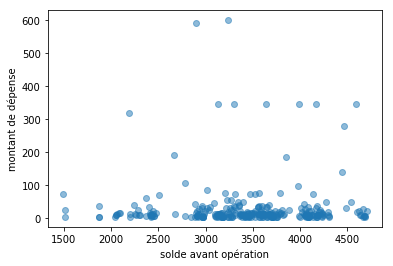

In [9]:
# Diagramme de dispersion (taille de depense // montant de solde restant) ; scatterplot
depenses = data[data.montant < 0]
plt.plot(depenses["solde_avt_ope"],-depenses["montant"],'o',alpha=0.5)
plt.xlabel("solde avant opération")
plt.ylabel("montant de dépense")
plt.show()

In [10]:
# coefficient de Pearson (correlation  lineaire) ; attention detecte seulement corrélation lineaire
# si pearson proche de 0 : pas corrélé; si pearson proche de 1 : corrélé; si proche de -1 : correlation inverse
print(st.pearsonr(depenses["solde_avt_ope"],-depenses["montant"])[0])

#covariance donne une matrice 4 valeur ... la seconde de premiere ligne
print(np.cov(depenses["solde_avt_ope"],-depenses["montant"],ddof=0)[1,0])

0.01006881913375922
484.95954154532865


[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]
[ 250.  750. 1250. 1750. 2250. 2750. 3250. 3750. 4250. 4750.]


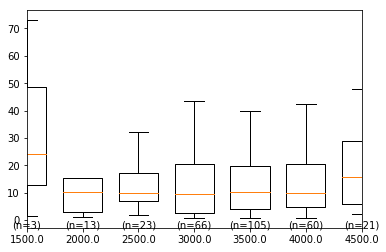

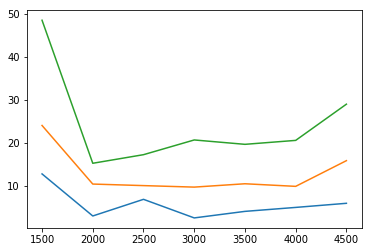

In [19]:
taille_classe = 500 # taille des classes pour la discrétisation

groupes = [] # va recevoir les données agrégées à afficher

# on calcule des tranches allant de 0 au solde maximum par paliers de taille taille_classe
tranches = np.arange(0, max(depenses["solde_avt_ope"]), taille_classe)
print(tranches)
tranches += taille_classe/2 # on décale les tranches d'une demi taille de classe
print(tranches)
indices = np.digitize(depenses["solde_avt_ope"], tranches) # associe chaque solde à son numéro de classe

for ind, tr in enumerate(tranches): # pour chaque tranche, ind reçoit le numéro de tranche et tr la tranche en question
    montants = -depenses.loc[indices==ind,"montant"] # sélection des individus de la tranche ind
    if len(montants) > 0:
        g = {
            'valeurs': montants,
            'centre_classe': tr-(taille_classe/2),
            'taille': len(montants),
            'quartiles': [np.percentile(montants,p) for p in [25,50,75]]
        }
        groupes.append(g)

# affichage des boxplots
plt.boxplot([g["valeurs"] for g in groupes],
            positions= [g["centre_classe"] for g in groupes], # abscisses des boxplots
            showfliers= False, # on ne prend pas en compte les outliers
            widths= taille_classe*0.7, # largeur graphique des boxplots
)

# affichage des effectifs de chaque classe en valeur SOUS GRAPHE
for g in groupes:
    plt.text(g["centre_classe"],0,"(n={})".format(g["taille"]),horizontalalignment='center',verticalalignment='top')     
plt.show()

# affichage des quartiles
for n_quartile in range(3):
    plt.plot([g["centre_classe"] for g in groupes],
             [g["quartiles"][n_quartile] for g in groupes])
plt.show()

In [17]:
# -----------------------------
# ANNALYSE BIVARIé DE VARIABLES QUANTITATIVES PAR REGRESSION LINEAIRE
# -----------------------------
import datetime as dt
# Selection du sous-échantillon
courses = data[data.categ == "COURSES"]

# On trie les opérations par date
courses = courses.sort_values("date_operation")

# On ramène les montants en positif
courses["montant"] = -courses["montant"]

# calcul de la variable attente
r = []
last_date = dt.datetime.now()
for i,row in courses.iterrows():
    days = (row["date_operation"]-last_date).days
    if days == 0:
        r.append(r[-1])
    else:
        r.append(days)
    last_date = row["date_operation"]
courses["attente"] = r
courses = courses.iloc[1:,]

# on regroupe les opérations qui ont été effectués à la même date
# (courses réalisées le même jour mais dans 2 magasins différents)
a = courses.groupby("date_operation")["montant"].sum()
b = courses.groupby("date_operation")["attente"].first()
courses = pd.DataFrame({"montant":a, "attente":b})

1.7365779467680629
10.944847908745242


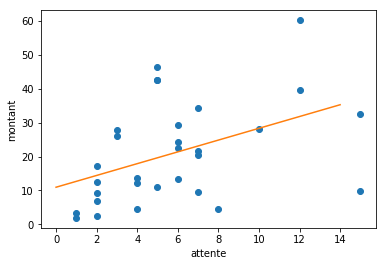

In [16]:
import statsmodels.api as sm
Y = courses['montant'] # variable a predire (1 seule colonne :serie)
X = courses[['attente']] # variables de determination ( potentiellement plusieurs, donc [[]] : dataframe)
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['attente'],result.params['intercept']
print(a) # estimation OLS  linear parameter : Y = aX+b
print(b)

#graphique 
plt.plot(courses.attente,courses.montant, "o") #definition nuage de points
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)]) # series de point pour traçage courbe de regression
#création de 15 valeurs unitaire d'abscice, et calculs des ordonnées selon modèle

plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

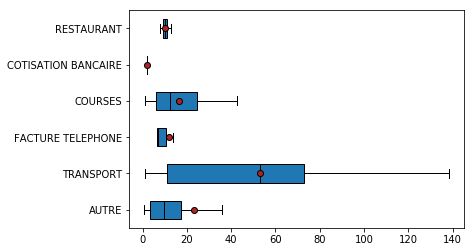

In [20]:
# -----------------------------
# ANNALYSE BIVARIé DE VARIABLES QUANTITATIVES & QUALITATIVE PAR ANalysis Of VAriance (ANOVA)
# -----------------------------
X = "categ" # qualitative
Y = "montant" # quantitative

# On ne garde que les dépenses
sous_echantillon = data[data["montant"] < 0].copy()
# On remet les dépenses en positif
sous_echantillon["montant"] = -sous_echantillon["montant"]
# On n'étudie pas les loyers car trop gros:
sous_echantillon = sous_echantillon[sous_echantillon["categ"] != "LOYER"]

#CREATION DU GRAPHIQUE
modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()
# POINT ROUGES = MOYENNE = MEANPROPS
# AFFICHAGE PLOTBOX bars en quartiles

In [21]:
# rapport de correlation
# SCT est ici appelé variation totale (les anglophones utilisent plutôt Total Sum of Squares)
# SCE est ici appelé variation interclasse (Sum of Squares of the Model)
# SCR est ici appelé variation intraclasse (Sum of Squares of the Error) car s2i est la variance au sein de la classe i .

X = "categ" # qualitative
Y = "montant" # quantitative

sous_echantillon = data[data["montant"] < 0] # On ne garde que les dépenses

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

# si valeur 0 = pas de correlation ; 1.0 : correlation parfaite
eta_squared(sous_echantillon[X],sous_echantillon[Y]) 

0.39841890401094926

In [22]:
# -----------------------------
# ANNALYSE BIVARIé DE VARIABLES QUANTITATIVES par Chi-2
# -----------------------------
X = "quart_mois"
Y = "categ"

#Tableau de contingence (PIVOT_TABLE)
cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

categ,AUTRE,COTISATION BANCAIRE,COURSES,FACTURE TELEPHONE,LOYER,RESTAURANT,TRANSPORT,Total
quart_mois,,,,,,,,
1,55.0,7.0,6.0,6.0,NaN,3.0,9.0,86
2,45.0,NaN,11.0,1.0,6.0,7.0,6.0,76
3,60.0,NaN,7.0,NaN,NaN,4.0,4.0,75
4,52.0,NaN,15.0,NaN,NaN,2.0,2.0,71
Total,212.0,7.0,39.0,7.0,6.0,16.0,21.0,308


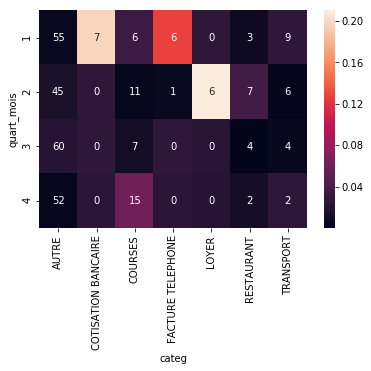

In [30]:
import seaborn as sns

# generation du tableau d'independance (CAS ou les variables sont totalement independantes)
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n #PRODUIT MATRICIEL
#print (indep)

c = cont.fillna(0) # On remplace les valeurs nulles par 0

# formule de comparaison entre contingence(reel) et le tableau d'independance
measure = (c-indep)**2/indep
#Normalisation de la mesure
xi_n = measure.sum().sum()
#calcul des contributions pour chaque valeur de measure
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1]) #sns.heatmap(measure/xi_n,annot=c)
plt.show()